# FROM TERMINAL, RUN THIS LINE:
jupyter nbconvert --execute --to html Crypto_Model_wSignalReversalDetection.ipynb

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
from model import MODEL
import utils, plotting, fstats_pct_chg
import pandas as pd

In [3]:
#your intra-day time at which to evaluate the model.
day_hour = 18
#your tickers of interest
tickers = ['BTC-USD']

In [4]:
#do not edit below this cell!

In [5]:
#specify dates:
todays_date = pd.Timestamp.today()
start_date = todays_date - pd.Timedelta('200 days')
filter_date = start_date.floor(freq='D').replace(hour=day_hour)
#get data:
model = MODEL(tickers=tickers)
model.get_data(start=start_date, interval='60m')
#filter by datetime:
date_range = utils.create_date_range(start_date=filter_date)
model.apply_date_filter(date_range, force_apply=True)
model.eval_model()

[*********************100%***********************]  1 of 1 completed
[INFO]: filter applied.
|                                 PRICE MODEL                                  |
|                                 Version 0.3                                  |
|                  Authors: Marco Rosenzweig & Patrick Lorenz                  |
--------------------------------------------------------------------------------
|                             ticker = ['BTC-USD']                             |
|                            start date = 02/19/20                             |
|                             end date = 09/05/20                              |
|                     initial investment per ticker = 200                      |
[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
********************************************************************************
[TICKER]: BTC-USD
[INFO]: Open position.
[INFO]: No tax paid.
[INFO]: Last entry of "S

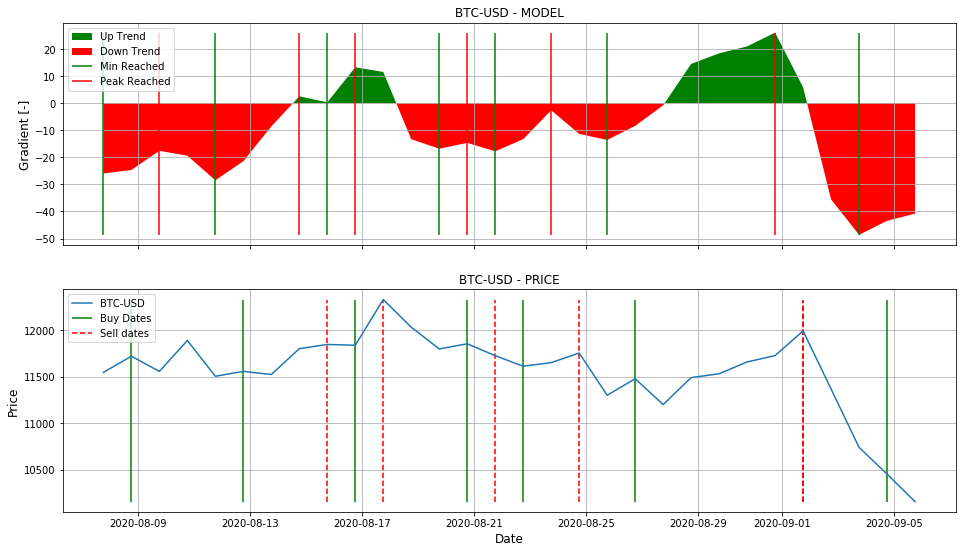

In [6]:
#plotting:
plot_date = todays_date - pd.Timedelta('30 days')
plot_start = str(plot_date.date())
plotting.plot_model(model, tickers='BTC-USD', plot_from_date=plot_start)

In [7]:
imag_model = model.copy_model()
imag_model.append_timedelta(timedelta=1)
imag_model.comp_break_values(tickers='all', parallel_computing=True)
imag_model._init_model()

[INFO]: New data was appended.
[INFO]: Compute break values with 30.00% deviation
[INFO]: Current ticker: BTC-USD
[INFO]: Using 10 processes.
[INFO]: Current values: {'BTC-USD': 10155.19140625}
[INFO]: Break values: {'BTC-USD': array([9683.990525  , 9765.23205625])}
[INFO]: Tolerances: {'BTC-USD': array([-471.20088125, -389.95935   ])}
[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
********************************************************************************


[INFO]: Current ticker: BTC-USD
--------------------------------------------------------------------------------
[INFO]: Result for value: 9562.940643438005
[INFO]: New sell signal was detected for last value: 9562.940643438005.


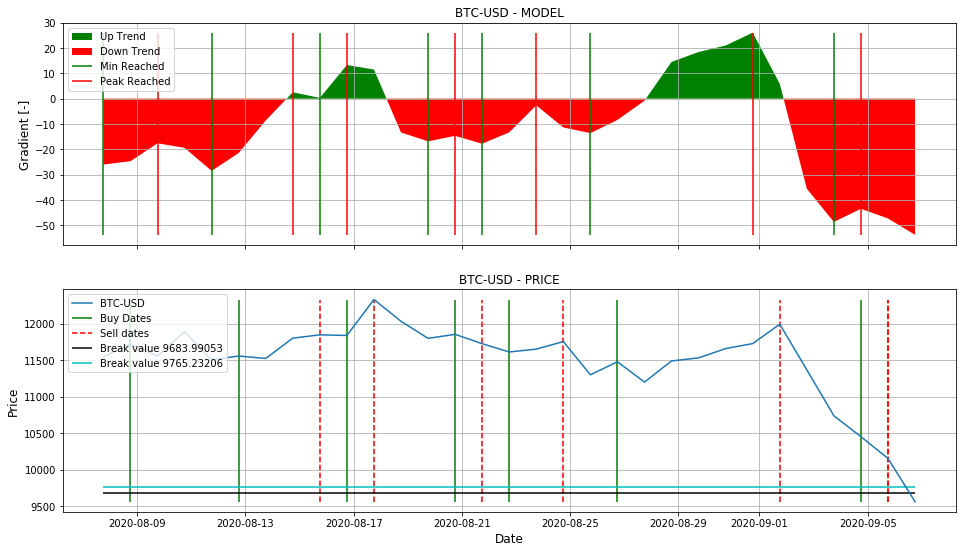

--------------------------------------------------------------------------------
[INFO]: Result for value: 9724.611290625518
[INFO]: New sell signal was detected for last value: 9724.611290625518.


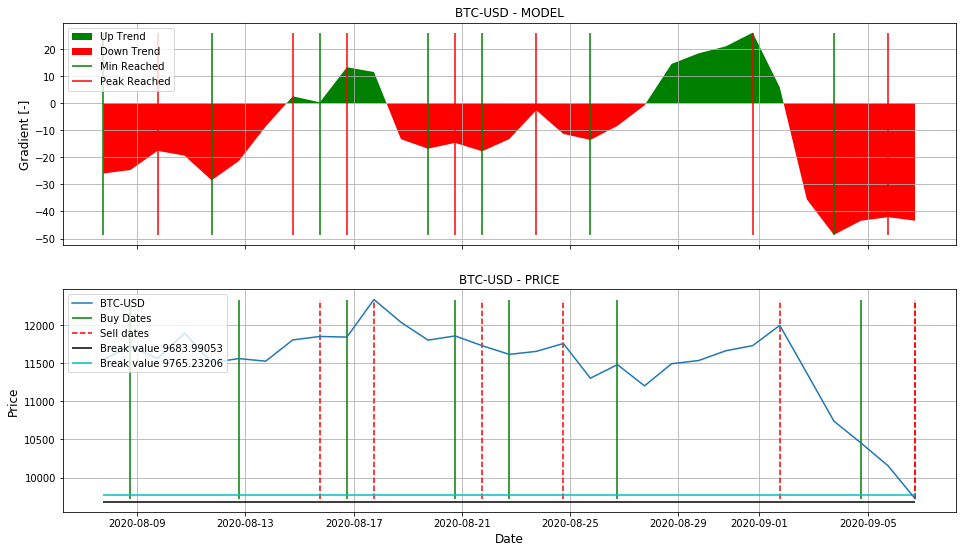

--------------------------------------------------------------------------------
[INFO]: Result for value: 9887.297456953658


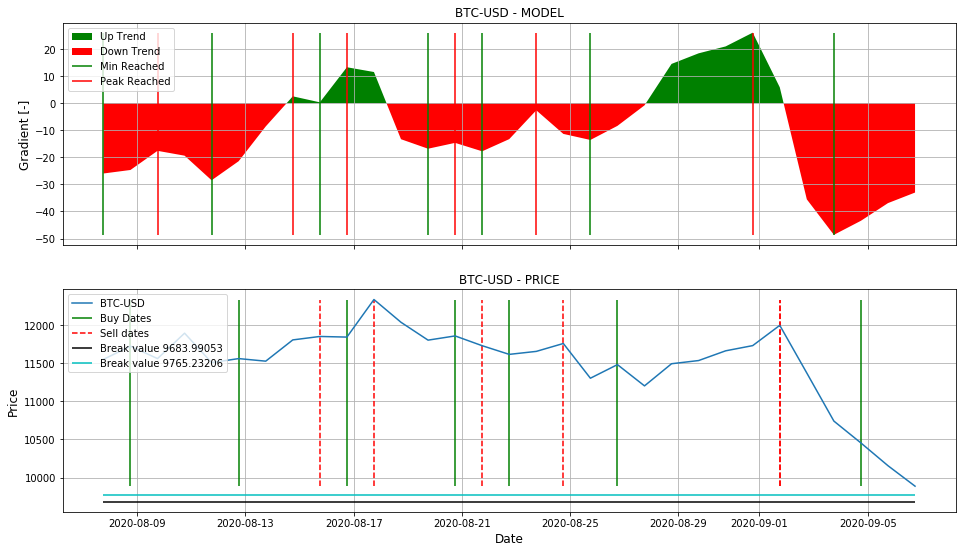

In [8]:
imag_model.show_possibilities(plot_from_date=plot_start, switch_axes=False)

[INFO]: Current ticker: BTC-USD
[*********************100%***********************]  1 of 1 completed
[STATS-INFO]: Auto update of tolerances!
[*********************100%***********************]  1 of 1 completed
[STATS-INFO]: Current value: 10174.7744140625!
[STATS-INFO]: New tolerances: [-490.78388906 -409.54235781]!
[STATS-EVAL]: Probability for tol=-0.04824: 9.60%
[STATS-EVAL]: Probability for tol=-0.04025: 13.58%
[STATS-EVAL]: Probability between: 3.98%


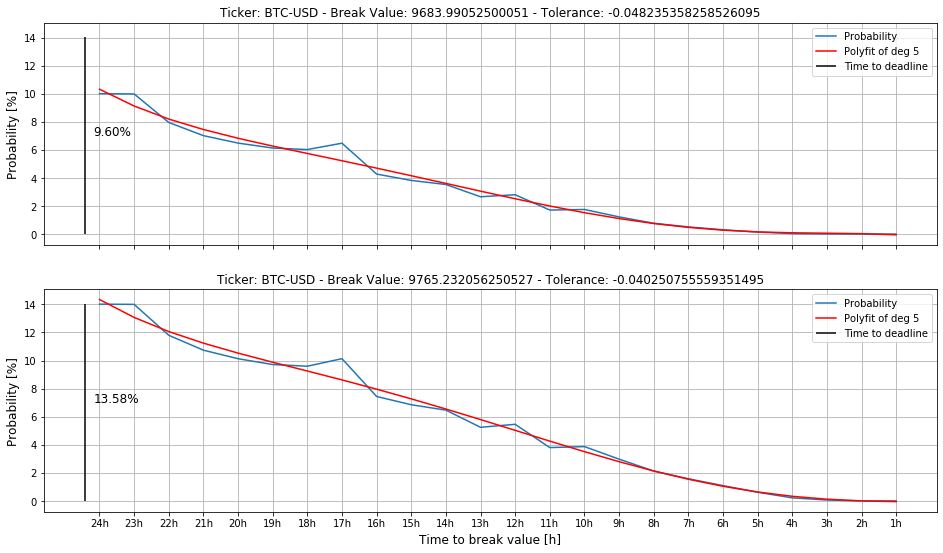

In [9]:
fstats_pct_chg.calc_probs(model=imag_model, tickers='all', auto_update_tolerances=True)

In [64]:
#trying to analyse how many signal reversals occured:
def exec_model(end_date):
    '''
    This function provides models and imag models in order to analyse singal reversals
    Inputs: 
    param: end_date: pd.Timestamp up to which the model is evaluated.
    Returns: 
    param: model: class MODEL, evaluated up to end_date
    param: imag_model: class MODEL, evaluated up to end_date + 1 day
    '''
    start_date = end_date - pd.Timedelta('200 days')
    filter_date = start_date.floor(freq='D').replace(hour=day_hour)
    #get data:
    model = MODEL(tickers=tickers)
    model.get_data(start=start_date, end=end_date, interval='60m')
    #filter by datetime:
    date_range = utils.create_date_range(start_date=filter_date)
    model.apply_date_filter(date_range, force_apply=True, do_print=False)
    model.eval_model(do_print=False)
    #calc imag model:
    imag_model = model.copy_model()
    imag_model.append_timedelta(timedelta=1, do_print=False)
    imag_model.comp_break_values(tickers='all', parallel_computing=True, do_print=False)
    imag_model._init_model(do_print=False)
    return model, imag_model

def compare_models(model_day_00, model_day_01, column, tickers='all', do_print=False):
    #real model has index 0, imag model has index 1
    if tickers == 'all':
        tickers = model_day_00[0].tickers
    for ticker in tickers:
        if do_print:
            print('Comparing "{}" for ticker "{}"'.format(column, ticker))
            last_imag_values = [pd.Timestamp(val).strftime('%Y-%m-%d') for val in model_day_00[1].ticker_df[ticker][column].values[-2:]]
            print('Imag model, last values: {}'.format(last_imag_values))
            last_real_values = [pd.Timestamp(val).strftime('%Y-%m-%d') for val in model_day_01[0].ticker_df[ticker][column].values[-2:]]
            print('Real model, last values: {}'.format(last_real_values))
        yield model_day_00[1].ticker_df[ticker][column].values[-2:] == model_day_01[0].ticker_df[ticker][column].values[-2:]
        
def get_red_bold(string):
    return "\x1B[1m{}".format("\x1B[31m{}".format(string))

In [77]:
import time
def detect_signal_reversal(n_days):
    print('+' * 78)
    print('Starting algorithm...')
    start_time = time.time()
    signal_reversal_dict = {}
    print('+' * 78)
    for n in range(n_days):
        print('-' * 78)
        today = pd.Timestamp.today()
        end_date = today - pd.Timedelta('{} days'.format(n))
        print('Evaluating model up to {} (today - {} days)'.format(end_date.strftime('%Y-%m-%d'), n))
        #compute models:
        model_day_00 = exec_model(end_date=end_date - pd.Timedelta('1 days'))
        model_day_01 = exec_model(end_date=end_date)
        #compare models:
        for column in ['Buy Dates', 'Sell Dates']:
            if not all(next(compare_models(model_day_00=model_day_00, model_day_01=model_day_01, column=column, 
                                           do_print=True))):
                utils._print_issue('ERROR', 'MISMATCHING "%s"' %column)
                try:
                    signal_reversal_dict[end_date.strftime('%Y-%m-%d')] += column
                except KeyError:
                    signal_reversal_dict[end_date.strftime('%Y-%m-%d')] = column
        print('-' * 78)
    print('+' * 78)
    print('Algorithm terminated normally after {:.2f}sec'.format(time.time() - start_time))
    print('+' * 78)
    return signal_reversal_dict

In [ ]:
n_days = 10
signal_reversal_dict = detect_signal_reversal(n_days=n_days)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Starting algorithm...
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
------------------------------------------------------------------------------
Evaluating model up to 2020-09-06 (today - 0 days)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Comparing "Buy Dates" for ticker "BTC-USD"
Imag model, last values: ['2020-08-26', '2020-09-04']
Real model, last values: ['2020-08-26', '2020-09-04']
Comparing "Sell Dates" for ticker "BTC-USD"
Imag model, last values: ['2020-09-01', '2020-09-01']
Real model, last values: ['2020-09-01', '2020-09-01']
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Evaluating model up to 2020-09-05 (today - 1 days)
[*********************100%**************

In [ ]:
if signal_reversal_dict == '{}':
    print('NO SIGNAL REVERSAL DETECTED')
else:
    for date, column in signal_reversal_dict.items():
        print(date, column)